<a href="https://colab.research.google.com/github/mherbert93/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [x] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [x] Plot a confusion matrix for your Tanzania Waterpumps model.
- [x] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [x] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [x] Commit your notebook to your fork of the GitHub repo.
- [x] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

train, validation = train_test_split(train, train_size=0.80, test_size=0.20, stratify=train['status_group'], random_state=1337)
train.shape, validation.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [0]:
target = 'status_group'

y_train = train[target]
y_validation = validation[target]

In [6]:
from sklearn.metrics import accuracy_score

majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

print("Train dataset baseline accuracy is: ", accuracy_score(y_train, y_pred))

Train dataset baseline accuracy is:  0.5430765993265994


In [7]:
y_pred = [majority_class] * len(y_validation)

print("Validation dataset baseline accuracy is: ", accuracy_score(y_validation, y_pred))

Validation dataset baseline accuracy is:  0.5430976430976431


In [0]:
def wrangle(X): #lets clean our data!
    import numpy as np
    from sklearn.cluster import DBSCAN

    X = X.copy()

    X['region_code'] = X['region_code'].astype('str') #make categorical
    X['district_code'] = X['district_code'].astype('str') #make categorical

    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

    zero_columns = ['district_code', 'construction_year'] #columns that contain high amount of 0 and should not
    X['latitude'] = X['latitude'].replace(-2e-08, 0)

    for col in zero_columns:
        X[col] = X[col].replace(0, np.nan) #set 0 values to null

    def impute_longitude_by_region(row): #bin null longitude into its respective region. Gives us a slighter better guess.
        if row['longitude'] == 0:
            return (X[(X['region'] == row['region']) & (X['longitude'] != 0)].longitude.mean())
        else:
            return row['longitude']


    def impute_latitude_by_region(row): #bin null latitude into its respective region. Gives us a slighter better guess.
        if row['latitude'] == 0:
            return (X[(X['region'] == row['region']) & (X['latitude'] != 0)].latitude.mean())
        else:
            return row['latitude']

    def impute_gpsheight(row): #bin null gps height into its respective region. Gives us a slighter better guess.
        if (row['gps_height'] == 0) and (row['region'] != 'Mbeya' and row['region'] != 'Kagera'
        and row['region'] != 'Dodoma' and row['region'] != 'Tabora'):
            return (X[(X['region'] == row['region']) & (X['gps_height'] != 0)].gps_height.mean())
        elif row['region'] == 'Mbeya':
            return 1348 #obtained from https://en-us.topographic-map.com/maps/ttgd/Mbeya/
        elif row['region'] == 'Kagera':
            return 1281 #obtained from https://en-us.topographic-map.com/maps/egpg/Kagera/
        elif row['region'] == 'Dodoma':
            return 1143 #obtained from https://en-us.topographic-map.com/maps/e6vm/Dodoma/
        elif row['region'] == 'Tabora':
            return 1177 #obtained from https://elevation.maplogs.com/poi/tabora_region_tanzania.214008.html
        elif row['gps_height'] < 0: #we should not have negative values here
            return 0
        else:
            return row['gps_height']

    #X['longitude'] = X.apply(impute_longitude_by_region, axis=1)
    #X['latitude'] = X.apply(impute_latitude_by_region, axis=1)

    X['gps_height'] = X.apply(impute_gpsheight, axis=1) #4 regions do not contain any gps height data. We will manually apply an average obtained for each region
                                                        #we will obtain this from https://en-us.topographic-map.com/maps/tlwx/Tanzania/
                                                        #we will go with the assumption that gps_height is in meters.
                                                        #we conclude this because the average gps_height, with zeros removed, is 1021. The average elevation in Tanzania is 936.
                                                        #We can infer based on the similarity in means, that the unit of measurement is meters.

    avg_years_old = X['date_recorded'].dt.year.mean() - X['construction_year'].mean()
    avg_years_old = int(avg_years_old)


    X['years_old'] = X['date_recorded'].dt.year - X['construction_year'] #how many years since inspection
    X['years_old'] = X['years_old'].fillna(value=avg_years_old) #fill nulls with average diff
    X['years_old'] = [y if y >= 0 else 0 for y in X['years_old']]


    #X['month_recorded'] = X['date_recorded'].dt.month

    X = X.drop(['quantity_group', 'recorded_by', 'date_recorded', 'wpt_name',
                'extraction_type_group', 'waterpoint_type_group',
                'source_type', 'quality_group', 'payment_type',
                'management_group', 'extraction_type_class',
                'num_private', 'scheme_name', 'source_class',
                'scheme_management', 'amount_tsh',
                'population', 'subvillage'], axis=1) #drop recorded by as its a constant. drop quantity_group as its a duplicate column.

    return X




In [9]:
train = wrangle(train)
validation = wrangle(validation)
test = wrangle(test)

train.shape

(47520, 24)

In [0]:
train_features = train.drop([target, 'id'], axis=1)
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

categorical_features = train_features.select_dtypes(exclude='number').nunique().index.tolist()


features = numeric_features + categorical_features

In [0]:
y_train = train[target]
X_train = train[features]
y_validation = validation[target]
X_validation = validation[features]
X_test = test[features]

In [0]:
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.pipeline import Pipeline

train_pipeline = Pipeline([#('encoder', ce.OneHotEncoder(use_cat_names=True)),
                           ('encoder', ce.OrdinalEncoder()),
                           ('imputer', SimpleImputer(strategy='median')),
                           ('model', XGBClassifier(seed=1337, objective='binary:logistic', booster='gbtree',
                                                   n_estimators=180, subsample=1, min_child_weight=1,
                                                   min_child_leaf=2, max_depth=14, learning_rate=0.04,
                                                   gamma=0, colsample_bytree=0.4))])

train_pipeline.fit(X_train, y_train)
y_pred = train_pipeline.predict(X_validation)
train_pred = train_pipeline.predict(X_train)
test_pred = train_pipeline.predict(X_test)

In [13]:
print("Validation accuracy score:", accuracy_score(y_validation, y_pred), "                    Train accuracy is: ", accuracy_score(y_train, train_pred))

Validation accuracy score: 0.8126262626262626                     Train accuracy is:  0.9386574074074074


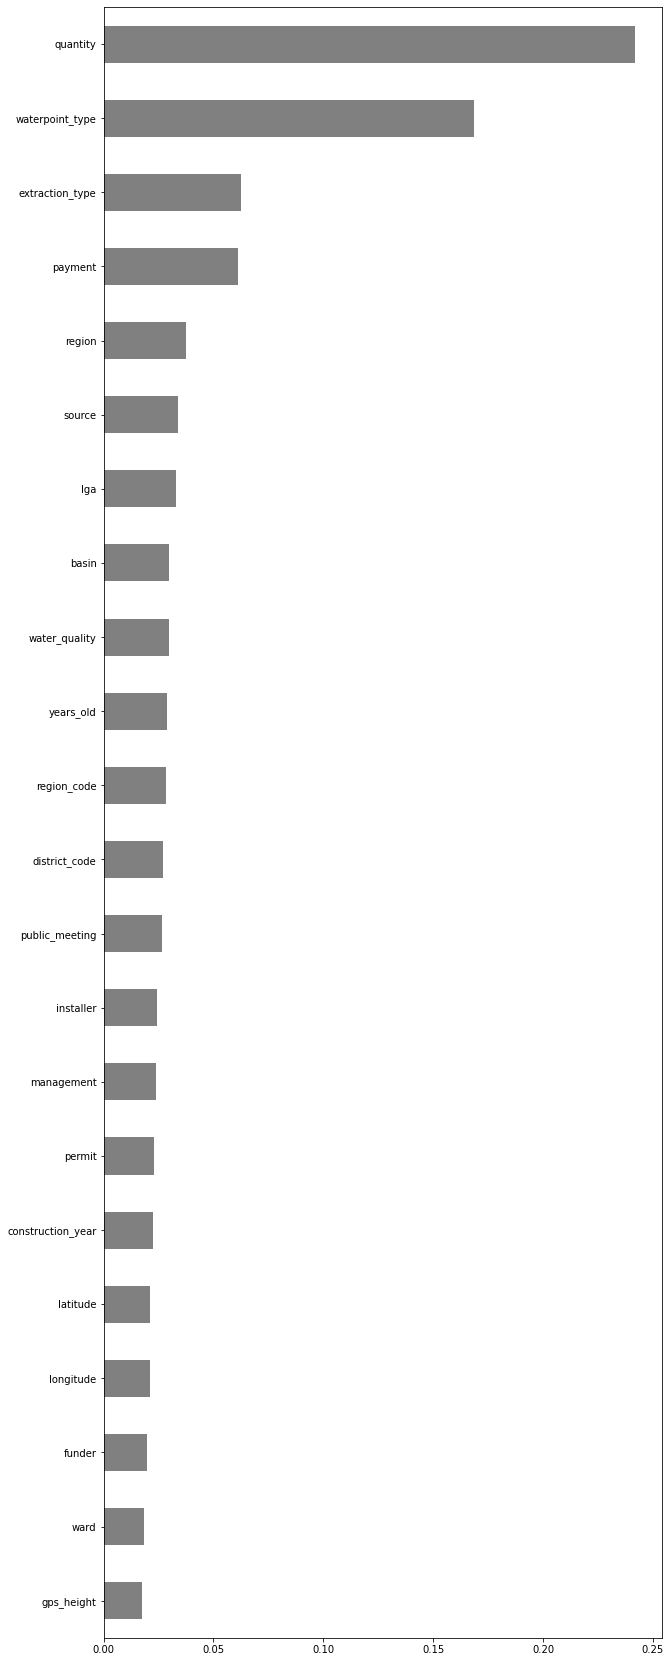

In [15]:
import matplotlib.pyplot as plt

model = train_pipeline.named_steps.model
encoder = train_pipeline.named_steps.encoder

encoded_columns = encoder.transform(X_validation).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

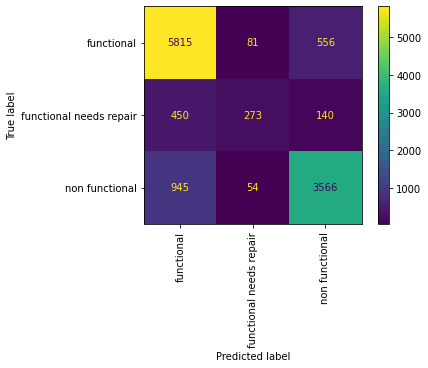

In [20]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(train_pipeline, X_validation, y_validation, values_format='.0f', xticks_rotation='vertical');